In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_50_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
1,LGBMClassifier,"'DS_BENCH_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
2,LGBMClassifier,"'DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
4,LGBMClassifier,"'DS_BENCH_50_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_50_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_50_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , 300, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (17650, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', MLPClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', Perceptron_pipe 18 18
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'firebird', AdaBoostClassifier_pipe 18 10
MODEL_DATASETS_MISSING 'firebird', BaggingClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'firebird', ExtraTreesClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'firebird', GradientBoostingClassifier_pipe 18 14
MODEL_DATASETS_MISSING 'firebird', LGBMClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'firebird', LinearDiscriminantAnalysis_pipe 18 18
MODEL_DATASETS_MISSING 'firebird', LogisticRegressionCV_pipe 18 18
MODEL_DATASETS_MISSING 'firebird', LogisticRegression_pipe 18 18
MODEL_DATASETS_MISSING 'firebird', MLPC

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
1,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__2_3_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
2,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__8_9_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
3,MLPClassifier_pipe,"'p_DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
4,MLPClassifier_pipe,"'p_DS_BENCH_50_7_0_1__2_3_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(18432, 8)

In [19]:
df.est_dialect.value_counts()

'teradata',    2048
'firebird',    2048
'mssql',       2048
'db2',         2048
'oracle',      2048
'pgsql',       2048
'monetdb',     2048
'sqltm',       2048
'mysql',       2048
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'firebird', TIMEOUT                                                       233
            'DatabaseError:(fdb.fbcore.DatabaseError)                     223
'monetdb',  TIMEOUT                                                       142
'sqltm',    TIMEOUT                                                        92
'mysql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'oracle',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'pgsql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mssql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'monetdb',  "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'firebird', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'db2',      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'sqltm',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'teradata', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mysql',    "InternalError:(_mysql_exceptions.InternalError)               85
'teradata', TIMEOUT                                                        84
'pgsql',    TIMEOUT                                                        74
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   74
'mysql',    TIMEOUT                                                        74
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   71
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   67
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   64
'monetdb',  "DatabaseError:(pymonetdb.exceptions.DatabaseEr...             63
'teradata', 'DatabaseError:(teradata.api.DatabaseError)                    61
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'db2',      TIMEOUT                                                        44
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   43
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   41
'oracle',   TIMEOUT                                                        34
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                      18
'mssql',    701, b"There is insufficient system memory in r...             12
'sqltm',    ) too many terms in compound SELEC                              6
'pgsql',    ) value out of range: underflo                                  6
            ) target lists can have at most 1664 entrie                     6
'sqltm',    ) too many columns in result se                                 6
'teradata', "DatabaseError:(teradata.api.DatabaseError)                     6
'db2',      'DBAPIError:(ibm_db_dbi.Error)                                  6
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
'monetdb',  ) Math exception: Numerical result out of rang                  6
'mssql',    TIMEOUT                                                         5
'monetdb',  'DBAPIError:(builtins.BrokenPipeError)                          3
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
'mssql',    8631, b'Internal error: Server stack limit has ...              2
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              2
'pgsql',    ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
        

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,15761
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",810
TIMEOUT,782
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",543
'DatabaseError:(fdb.fbcore.DatabaseError),223
"""InternalError:(_mysql_exceptions.InternalError)",85
"""DatabaseError:(pymonetdb.exceptions.DatabaseError)",63
'DatabaseError:(teradata.api.DatabaseError),61
"""DatabaseError:(fdb.fbcore.DatabaseError)",18
"701, b""There is insufficient system memory in resource pool 'default' to run this query.DB-Lib error message 20018, severity 17:General SQL Server error: Check messages from the SQL Server""",12


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

DummyClassifier                162
DummyClassifier_pipe           142
IsolationForest                 48
IsolationForest_pipe            48
NuSVC_pipe                      36
FastICA                         24
OneVsRestClassifier             24
FactorAnalysis                  18
Lars                             8
ExtraTreesClassifier             7
ExtraTreesClassifier_pipe        7
AdaBoostClassifier_pipe          3
RandomForestClassifier_pipe      3
MultinomialNB                    3
OneVsRestClassifier_pipe         3
BernoulliNB                      3
AdaBoostClassifier               3
EllipticEnvelope                 1
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

NMF                          162
SparsePCA                    162
MiniBatchSparsePCA           162
LatentDirichletAllocation    162
KernelPCA                    162
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_50_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_50_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_50_82_0_1__0_1_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_50_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_50_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_200_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_50_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird monetdb mssql mysql oracle pgsql   
model_category                                                                  
lightgbm.sklearn                 48       48      48    48    48     48    48   
sklearn.calibration              36       36      36    36    36     36    36   
sklearn.covariance               12       12      12    12    12     12    12   
sklearn.decomposition            90       90      90    90    90     90    90   
sklearn.discriminant_analysis    36       36      36    36    36     36    36   
sklearn.ensemble                252      252     252   252   252    252   252   
sklearn.feature_selection       162      162     162   162   162    162   162   
sklearn.kernel_ridge             12       12      12    12    12     12    12   
sklearn.linear_model            482      482     482   482   482    482   482   
sklearn.multiclass               72       72      72    72    72     72    72   
sklearn.naive_bayes              90       90      90    90    90     90    90   
sklearn.neural_network           48       48      48    48    48     48    48   
sklearn.pipeline                 54       54      54    54    54     54    54   
sklearn.preprocessing           216      216     216   216   216    216   216   
sklearn.svm                     156      156     156   156   156    156   156   
sklearn.tree                     96       96      96    96    96     96    96   
xgboost.sklearn                  48       48      48    48    48     48    48   
All                            1910     1910    1910  1910  1910   1910  1910   

                                                     
dialect                       sqltm teradata    All  
model_category                                       
lightgbm.sklearn                 48       48    432  
sklearn.calibration              36       36    324  
sklearn.covariance               12       12    108  
sklearn.decomposition            90       90    810  
sklearn.discriminant_analysis    36       36    324  
sklearn.ensemble                252      252   2268  
sklearn.feature_selection       162      162   1458  
sklearn.kernel_ridge             12       12    108  
sklearn.linear_model            482      482   4338  
sklearn.multiclass               72       72    648  
sklearn.naive_bayes              90       90    810  
sklearn.neural_network           48       48    432  
sklearn.pipeline                 54       54    486  
sklearn.preprocessing           216      216   1944  
sklearn.svm                     156      156   1404  
sklearn.tree                     96       96    864  
xgboost.sklearn                  48       48    432  
All                            1910     1910  17190

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   monetdb     mssql   
model_category                                                          
lightgbm.sklearn               0.000000  0.416667  0.000000  0.020833   
sklearn.calibration            0.000000  0.194444  0.722222  0.000000   
sklearn.covariance             0.166667  0.166667  0.666667  0.166667   
sklearn.decomposition          0.033333  0.100000  0.244444  0.033333   
sklearn.discriminant_analysis  0.000000  0.583333  0.000000  0.000000   
sklearn.ensemble               0.051587  0.396825  0.047619  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.583333  0.000000  0.000000   
sklearn.linear_model           0.045643  0.105809  0.004149  0.008299   
sklearn.multiclass             0.041667  0.708333  0.041667  0.055556   
sklearn.naive_bayes            0.066667  1.000000  0.622222  0.233333   
sklearn.neural_network         0.375000  0.250000  0.000000  0.020833   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.055556  0.083333  0.050926  0.000000   
sklearn.svm                    0.044872  0.448718  0.711538  0.038462   
sklearn.tree                   0.031250  0.052083  0.000000  0.000000   
xgboost.sklearn                0.020833  0.333333  0.020833  0.000000   
All                            0.047120  0.250785  0.131937  0.028272   

                                                                       \
dialect                           mysql    oracle     pgsql     sqltm   
model_category                                                          
lightgbm.sklearn               0.000000  0.125000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.500000   
sklearn.covariance             0.166667  0.666667  0.166667  0.166667   
sklearn.decomposition          0.033333  0.033333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.047619  0.119048  0.119048  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.118257  0.006224  0.006224  0.006224   
sklearn.multiclass             0.111111  0.041667  0.541667  0.291667   
sklearn.naive_bayes            0.922222  0.000000  0.066667  0.000000   
sklearn.neural_network         0.000000  0.000000  0.000000  0.375000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.333333   
sklearn.preprocessing          0.000000  0.000000  0.027778  0.055556   
sklearn.svm                    0.038462  0.038462  0.038462  0.038462   
sklearn.tree                   0.187500  0.000000  0.187500  0.000000   
xgboost.sklearn                0.000000  0.020833  0.000000  0.000000   
All                            0.098953  0.031414  0.059162  0.059162   

                                                   
dialect                        teradata       All  
model_category                                     
lightgbm.sklearn               0.062500  0.069444  
sklearn.calibration            0.000000  0.157407  
sklearn.covariance             0.166667  0.277778  
sklearn.decomposition          0.033333  0.064198  
sklearn.discriminant_analysis  0.000000  0.064815  
sklearn.ensemble               0.138889  0.112875  
sklearn.feature_selection      0.000000  0.000000  
sklearn.kernel_ridge           0.000000  0.064815  
sklearn.linear_model           0.043568  0.038266  
sklearn.multiclass             0.041667  0.208333  
sklearn.naive_bayes            0.855556  0.418519  
sklearn.neural_network         0.000000  0.113426  
sklearn.pipeline               0.000000  0.037037  
sklearn.preprocessing          0.055556  0.036523  
sklearn.svm                    0.192308  0.176638  
sklearn.tree                   

In [38]:
df.to_csv('report_extensive_tests.csv')

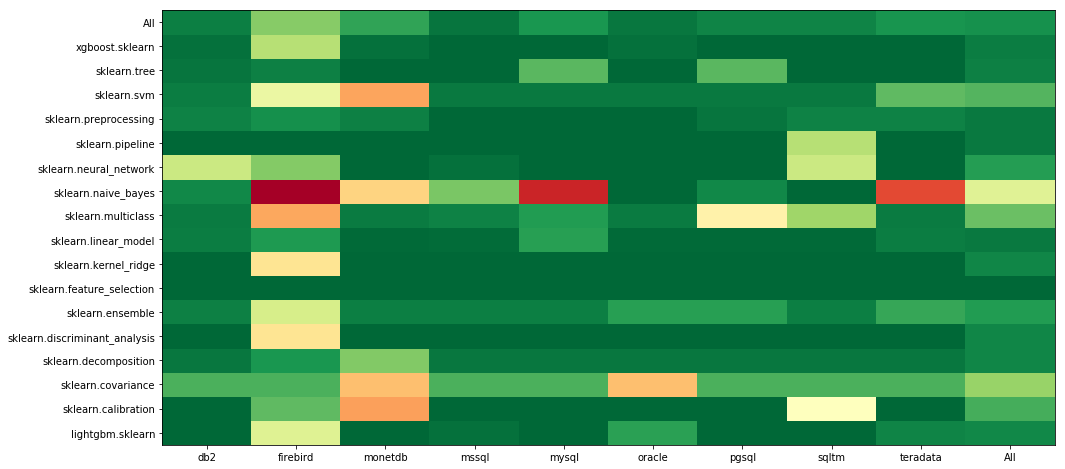

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', SUCCESS                                                        28
            TIMEOUT                                                        16
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        47
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        42
            TIMEOUT                                                         6
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        45
            'DatabaseError:(teradata.api.DatabaseError)                     3

mean                                                       \
dialect              db2  firebird monetdb     mssql mysql oracle pgsql sqltm   
Model                                                                           
LGBMClassifier       0.0  0.166667     0.0  0.000000   0.0  0.000   0.0   0.0   
LGBMClassifier_pipe  0.0  0.888889     0.0  0.055556   0.0  0.000   0.0   0.0   
LGBMRegressor        0.0  0.166667     0.0  0.000000   0.0  0.000   0.0   0.0   
LGBMRegressor_pipe   0.0  0.000000     0.0  0.000000   0.0  1.000   0.0   0.0   
All                  0.0  0.416667     0.0  0.020833   0.0  0.125   0.0   0.0   

                                         
dialect              teradata       All  
Model                                    
LGBMClassifier       0.000000  0.018519  
LGBMClassifier_pipe  0.166667  0.123457  
LGBMRegressor        0.000000  0.018519  
LGBMRegressor_pipe   0.000000  0.111111  
All                  0.062500  0.069444

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message               
'db2',      SUCCESS                   36
'firebird', SUCCESS                   29
            TIMEOUT                    7
'monetdb',  TIMEOUT                   26
            SUCCESS                   10
'mssql',    SUCCESS                   36
'mysql',    SUCCESS                   36
'oracle',   SUCCESS                   36
'pgsql',    SUCCESS                   36
'sqltm',    SUCCESS                   18
            TIMEOUT                   18
'teradata', SUCCESS                   36

mean                                               \
dialect                      db2  firebird   monetdb mssql mysql oracle pgsql   
Model                                                                           
CalibratedClassifierCV       0.0  0.000000  0.444444   0.0   0.0    0.0   0.0   
CalibratedClassifierCV_pipe  0.0  0.388889  1.000000   0.0   0.0    0.0   0.0   
All                          0.0  0.194444  0.722222   0.0   0.0    0.0   0.0   

                                                      
dialect                     sqltm teradata       All  
Model                                                 
CalibratedClassifierCV        0.0      0.0  0.049383  
CalibratedClassifierCV_pipe   1.0      0.0  0.265432  
All                           0.5      0.0  0.157407

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  TIMEOUT                                                         7
            SUCCESS                                                         4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   TIMEOUT                                                         8
            SUCCESS                                                         4
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   monetdb     mssql     mysql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  1.000000  0.000000  0.000000   
All                    0.166667  0.166667  0.666667  0.166667  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333  
EllipticEnvelope_pipe  1.000000  0.000000  0.000000  0.000000  0.222222  
All                    0.666667  0.166667  0.166667  0.166667  0.277778

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                  81
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
            "DatabaseError:(fdb.fbcore.DatabaseError)                 3
'monetdb',  SUCCESS                                                  68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             21
            TIMEOUT                                                   1
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect              db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.222222  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
All             0.033333  0.100000  0.244444  0.033333  0.033333  0.033333   

                                                        
dialect            pgsql     sqltm  teradata       All  
Model                                                   
FactorAnalysis  0.000000  0.000000  0.000000  0.111111  
FastICA         0.166667  0.166667  0.166667  0.191358  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  
PCA             0.000000  0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000  0.000000  0.018519  
All             0.033333  0.033333  0.033333  0.064198

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message               
'db2',      SUCCESS                   36
'firebird', TIMEOUT                   21
            SUCCESS                   15
'monetdb',  SUCCESS                   36
'mssql',    SUCCESS                   36
'mysql',    SUCCESS                   36
'oracle',   SUCCESS                   36
'pgsql',    SUCCESS                   36
'sqltm',    SUCCESS                   36
'teradata', SUCCESS                   36

mean                                       \
dialect                          db2  firebird monetdb mssql mysql oracle   
Model                                                                       
LinearDiscriminantAnalysis       0.0  0.166667     0.0   0.0   0.0    0.0   
LinearDiscriminantAnalysis_pipe  0.0  1.000000     0.0   0.0   0.0    0.0   
All                              0.0  0.583333     0.0   0.0   0.0    0.0   

                                                                
dialect                         pgsql sqltm teradata       All  
Model                                                           
LinearDiscriminantAnalysis        0.0   0.0      0.0  0.018519  
LinearDiscriminantAnalysis_pipe   0.0   0.0      0.0  0.111111  
All                               0.0   0.0      0.0  0.064815

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       239
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       152
            TIMEOUT                                                        61
            'DatabaseError:(fdb.fbcore.DatabaseError)                      33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mysql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'oracle',   SUCCESS                                                       222
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                       222
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', SUCCESS                                                       217
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   29
            'DatabaseError:(teradata.api.DatabaseError)                     6

mean                                \
dialect                               db2  firebird   monetdb     mssql   
Model                                                                     
AdaBoostClassifier               0.000000  0.833333  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.722222  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.055556  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.666667  0.000000  0.000000   
BaggingRegressor                 0.000000  0.166667  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.333333  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.666667  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.166667  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.166667  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.777778  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.722222  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.051587  0.396825  0.047619  0.047619   

                                                                         \
dialect                             mysql    oracle     pgsql     sqltm   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  1.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.000000  1.000000  0.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.047619  0.119048  0.119048  0.047619   

                                                     
dialect                          teradata       All  
Model                      

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,162
"'firebird',",SUCCESS,162
"'monetdb',",SUCCESS,162
"'mssql',",SUCCESS,162
"'mysql',",SUCCESS,162
"'oracle',",SUCCESS,162
"'pgsql',",SUCCESS,162
"'sqltm',",SUCCESS,162
"'teradata',",SUCCESS,162


mean                                                  \
dialect                  db2 firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                          
GenericUnivariateSelect    0        0       0     0     0      0     0     0   
RFE                        0        0       0     0     0      0     0     0   
RFECV                      0        0       0     0     0      0     0     0   
SelectFdr                  0        0       0     0     0      0     0     0   
SelectFpr                  0        0       0     0     0      0     0     0   
SelectFromModel            0        0       0     0     0      0     0     0   
SelectFwe                  0        0       0     0     0      0     0     0   
SelectKBest                0        0       0     0     0      0     0     0   
SelectPercentile           0        0       0     0     0      0     0     0   
All                        0        0       0     0     0      0     0     0   

                                      
dialect                 teradata All  
Model                                 
GenericUnivariateSelect        0   0  
RFE                            0   0  
RFECV                          0   0  
SelectFdr                      0   0  
SelectFpr                      0   0  
SelectFromModel                0   0  
SelectFwe                      0   0  
SelectKBest                    0   0  
SelectPercentile               0   0  
All                            0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               12
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)              5
            SUCCESS                                                5
            'DatabaseError:(fdb.fbcore.DatabaseError)              2
'monetdb',  SUCCESS                                               12
'mssql',    SUCCESS                                               12
'mysql',    SUCCESS                                               12
'oracle',   SUCCESS                                               12
'pgsql',    SUCCESS                                               12
'sqltm',    SUCCESS                                               12
'teradata', SUCCESS                                               12

mean                                                   \
dialect           db2  firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                    
KernelRidge       0.0  0.333333     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.833333     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.0  0.583333     0.0   0.0   0.0    0.0   0.0   0.0   

                                     
dialect          teradata       All  
Model                                
KernelRidge           0.0  0.037037  
KernelRidge_pipe      0.0  0.092593  
All                   0.0  0.064815

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       460
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       431
            TIMEOUT                                                        50
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'monetdb',  SUCCESS                                                       480
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                       478
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                       425
            TIMEOUT                                                        56
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       461
            TIMEOUT                                                        20
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2  firebird   monetdb     mssql   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.166667  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.166667  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.166667  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  1.000000  0.055556  0.000000   
LogisticRegression_pipe           0.000000  1.000000  0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.166667   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.111111  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   1.000000  0.000000  0.000000  0.000000   
RANSACRegressor                   1.000000  0.000000  0.000000  1.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.111111  0.000000  0.000000   
RidgeClassifier_pipe              0.000000  0.055556  0.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.166667  0.000000  0.000000   
SGDRegressor                      0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      28
            TIMEOUT                                                        23
            SUCCESS                                                        21
'monetdb',  SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mssql',    SUCCESS                                                        68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        64
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            "InternalError:(_mysql_exceptions.InternalError)                2
'oracle',   SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'pgsql',    TIMEOUT                                                        36
            SUCCESS                                                        33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'sqltm',    SUCCESS                                                        51
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'teradata', SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3

mean                                          \
dialect                        db2  firebird   monetdb     mssql     mysql   
Model                                                                        
OneVsOneClassifier        0.000000  0.166667  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  1.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier       0.166667  0.833333  0.166667  0.166667  0.166667   
OneVsRestClassifier_pipe  0.000000  0.833333  0.000000  0.055556  0.277778   
All                       0.041667  0.708333  0.041667  0.055556  0.111111   

                                                                            
dialect                     oracle     pgsql     sqltm  teradata       All  
Model                                                                       
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.018519  
OneVsOneClassifier_pipe   0.000000  1.000000  1.000000  0.000000  0.333333  
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  0.240741  
OneVsRestClassifier_pipe  0.000000  1.000000  0.000000  0.000000  0.240741  
All                       0.041667  0.541667  0.291667  0.041667  0.208333

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        84
            'DBAPIError:(ibm_db_dbi.Error)                                  6
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      81
            TIMEOUT                                                         9
'monetdb',  TIMEOUT                                                        50
            SUCCESS                                                        34
            ) Math exception: Numerical result out of rang                  6
'mssql',    SUCCESS                                                        69
            701, b"There is insufficient system memory in r...             12
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            TIMEOUT                                                         3
'mysql',    "InternalError:(_mysql_exceptions.InternalError)               83
            SUCCESS                                                         7
'oracle',   SUCCESS                                                        90
'pgsql',    SUCCESS                                                        84
            ) value out of range: underflo                                  6
'sqltm',    SUCCESS                                                        90
'teradata', TIMEOUT                                                        58
            'DatabaseError:(teradata.api.DatabaseError)                    19
            SUCCESS                                                        13

mean                                                \
dialect                db2 firebird   monetdb     mssql     mysql oracle   
Model                                                                      
BernoulliNB       0.000000      1.0  0.111111  0.500000  0.666667    0.0   
BernoulliNB_pipe  0.000000      1.0  1.000000  0.000000  0.944444    0.0   
GaussianNB        0.333333      1.0  1.000000  0.333333  1.000000    0.0   
GaussianNB_pipe   0.000000      1.0  1.000000  0.000000  1.000000    0.0   
MultinomialNB     0.000000      1.0  0.000000  0.333333  1.000000    0.0   
All               0.066667      1.0  0.622222  0.233333  0.922222    0.0   

                                                      
dialect              pgsql sqltm  teradata       All  
Model                                                 
BernoulliNB       0.000000   0.0  0.666667  0.327160  
BernoulliNB_pipe  0.000000   0.0  1.000000  0.438272  
GaussianNB        0.333333   0.0  0.944444  0.549383  
GaussianNB_pipe   0.000000   0.0  1.000000  0.444444  
MultinomialNB     0.000000   0.0  0.666667  0.333333  
All               0.066667   0.0  0.855556  0.418519

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        30
            TIMEOUT                                                        18
'firebird', SUCCESS                                                        36
            TIMEOUT                                                        12
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        47
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        30
            TIMEOUT                                                        18
'teradata', SUCCESS                                                        48

mean                                                 \
dialect               db2  firebird monetdb     mssql mysql oracle pgsql   
Model                                                                      
MLPClassifier       0.000  0.000000     0.0  0.000000   0.0    0.0   0.0   
MLPClassifier_pipe  1.000  0.666667     0.0  0.055556   0.0    0.0   0.0   
MLPRegressor        0.000  0.000000     0.0  0.000000   0.0    0.0   0.0   
MLPRegressor_pipe   0.000  0.000000     0.0  0.000000   0.0    0.0   0.0   
All                 0.375  0.250000     0.0  0.020833   0.0    0.0   0.0   

                                              
dialect             sqltm teradata       All  
Model                                         
MLPClassifier       0.000      0.0  0.000000  
MLPClassifier_pipe  1.000      0.0  0.302469  
MLPRegressor        0.000      0.0  0.000000  
MLPRegressor_pipe   0.000      0.0  0.000000  
All                 0.375      0.0  0.113426

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message               
'db2',      SUCCESS                   54
'firebird', SUCCESS                   54
'monetdb',  SUCCESS                   54
'mssql',    SUCCESS                   54
'mysql',    SUCCESS                   54
'oracle',   SUCCESS                   54
'pgsql',    SUCCESS                   54
'sqltm',    SUCCESS                   36
            TIMEOUT                   18
'teradata', SUCCESS                   54

mean                                                           \
dialect        db2 firebird monetdb mssql mysql oracle pgsql sqltm teradata   
Model                                                                         
FeatureUnion     0        0       0     0     0      0     0     0        0   
Pipeline         0        0       0     0     0      0     0     0        0   
Pipeline_pipe    0        0       0     0     0      0     0     1        0   
All              0        0       0     0     0      0     0     0        0   

                         
dialect             All  
Model                    
FeatureUnion   0.000000  
Pipeline       0.000000  
Pipeline_pipe  0.111111  
All            0.037037

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       204
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            TIMEOUT                                                         6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'monetdb',  SUCCESS                                                       205
            TIMEOUT                                                        11
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       204
            "DatabaseError:(teradata.api.DatabaseError)                     6
            TIMEOUT                                                         6

mean                                         \
dialect                   db2  firebird   monetdb mssql mysql oracle   
Model                                                                  
Binarizer            0.000000  0.000000  0.000000   0.0   0.0    0.0   
Imputer              0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelBinarizer       0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelEncoder         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MaxAbsScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MinMaxScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
Normalizer           0.000000  0.000000  0.000000   0.0   0.0    0.0   
OneHotEncoder        0.000000  0.000000  0.000000   0.0   0.0    0.0   
PolynomialFeatures   0.333333  0.333333  0.611111   0.0   0.0    0.0   
QuantileTransformer  0.333333  0.666667  0.000000   0.0   0.0    0.0   
RobustScaler         0.000000  0.000000  0.000000   0.0   0.0    0.0   
StandardScaler       0.000000  0.000000  0.000000   0.0   0.0    0.0   
All                  0.055556  0.083333  0.050926   0.0   0.0    0.0   

                                                             
dialect                 pgsql     sqltm  teradata       All  
Model                                                        
Binarizer            0.000000  0.000000  0.000000  0.000000  
Imputer              0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures   0.333333  0.333333  0.333333  0.253086  
QuantileTransformer  0.000000  0.333333  0.333333  0.185185  
RobustScaler         0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  
All                  0.027778  0.055556  0.055556  0.036523

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       149
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        86
            'DatabaseError:(fdb.fbcore.DatabaseError)                      49
            TIMEOUT                                                        11
            "DatabaseError:(fdb.fbcore.DatabaseError)                      10
'monetdb',  "DatabaseError:(pymonetdb.exceptions.DatabaseEr...             63
            TIMEOUT                                                        47
            SUCCESS                                                        45
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'mysql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'oracle',   SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'pgsql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'sqltm',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'teradata', SUCCESS                                                       126
            'DatabaseError:(teradata.api.DatabaseError)                    30

mean                                                    \
dialect                db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                          
LinearSVC         0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.166667  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.833333  0.277778  0.000000  0.000000  0.000000   
NuSVC_pipe        0.333333  0.666667  1.000000  0.333333  0.333333  0.333333   
NuSVR             0.000000  0.166667  0.666667  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.500000  1.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.333333  1.000000  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.833333  0.333333  0.000000  0.000000  0.000000   
SVC_pipe          0.000000  0.666667  1.000000  0.000000  0.000000  0.000000   
SVR               0.000000  0.500000  1.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.833333  1.000000  0.000000  0.000000  0.000000   
All               0.044872  0.448718  0.711538  0.038462  0.038462  0.038462   

                                                          
dialect              pgsql     sqltm  teradata       All  
Model                                                     
LinearSVC         0.000000  0.000000  0.000000  0.111111  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.111111  
LinearSVR         0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.018519  
NuSVC             0.000000  0.000000  0.500000  0.179012  
NuSVC_pipe        0.333333  0.333333  0.500000  0.462963  
NuSVR             0.000000  0.000000  0.000000  0.092593  
NuSVR_pipe        0.000000  0.000000  0.000000  0.166667  
OneClassSVM       0.000000  0.000000  0.000000  0.148148  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.037037  
SVC               0.000000  0.000000  0.333333  0.166667  
SVC_pipe          0.000000  0.000000  0.333333  0.222222  
SVR               0.000000  0.000000  0.000000  0.166667  
SVR_pipe          0.000000  0.000000  0.000000  0.203704  
All               0.038462  0.038462  0.192308  0.176638

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        93
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        91
            TIMEOUT                                                         5
'monetdb',  SUCCESS                                                        96
'mssql',    SUCCESS                                                        96
'mysql',    SUCCESS                                                        78
            TIMEOUT                                                        18
'oracle',   SUCCESS                                                        96
'pgsql',    SUCCESS                                                        78
            TIMEOUT                                                        18
'sqltm',    SUCCESS                                                        96
'teradata', SUCCESS                                                        96

mean                                         \
dialect                           db2  firebird monetdb mssql   mysql oracle   
Model                                                                          
DecisionTreeClassifier       0.000000  0.000000     0.0   0.0  0.0000    0.0   
DecisionTreeClassifier_pipe  0.055556  0.166667     0.0   0.0  0.0000    0.0   
DecisionTreeRegressor        0.000000  0.000000     0.0   0.0  0.0000    0.0   
DecisionTreeRegressor_pipe   0.333333  0.000000     0.0   0.0  0.0000    0.0   
ExtraTreeClassifier          0.000000  0.000000     0.0   0.0  0.0000    0.0   
ExtraTreeClassifier_pipe     0.000000  0.111111     0.0   0.0  1.0000    0.0   
ExtraTreeRegressor           0.000000  0.000000     0.0   0.0  0.0000    0.0   
ExtraTreeRegressor_pipe      0.000000  0.000000     0.0   0.0  0.0000    0.0   
All                          0.031250  0.052083     0.0   0.0  0.1875    0.0   

                                                              
dialect                       pgsql sqltm teradata       All  
Model                                                         
DecisionTreeClassifier       0.0000   0.0      0.0  0.000000  
DecisionTreeClassifier_pipe  1.0000   0.0      0.0  0.135802  
DecisionTreeRegressor        0.0000   0.0      0.0  0.000000  
DecisionTreeRegressor_pipe   0.0000   0.0      0.0  0.037037  
ExtraTreeClassifier          0.0000   0.0      0.0  0.000000  
ExtraTreeClassifier_pipe     0.0000   0.0      0.0  0.123457  
ExtraTreeRegressor           0.0000   0.0      0.0  0.000000  
ExtraTreeRegressor_pipe      0.0000   0.0      0.0  0.000000  
All                          0.1875   0.0      0.0  0.050926

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        47
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        32
            TIMEOUT                                                        16
'monetdb',  SUCCESS                                                        47
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        47
            'DatabaseError:(cx+Oracle.DatabaseError)                        1
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                  \
dialect                  db2  firebird   monetdb mssql mysql    oracle pgsql   
Model                                                                          
XGBClassifier       0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
XGBClassifier_pipe  0.055556  0.888889  0.055556   0.0   0.0  0.055556   0.0   
XGBRegressor        0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
XGBRegressor_pipe   0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
All                 0.020833  0.333333  0.020833   0.0   0.0  0.020833   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
XGBClassifier        0.0      0.0  0.000000  
XGBClassifier_pipe   0.0      0.0  0.117284  
XGBRegressor         0.0      0.0  0.000000  
XGBRegressor_pipe    0.0      0.0  0.000000  
All                  0.0      0.0  0.043981

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
